In [8]:
#importing libraries
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,Flatten
from tensorflow.keras.models import Sequential

In [4]:
#trian image loading
train_data = tf.keras.utils.image_dataset_from_directory(
    'train',
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(128, 128),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 70295 files belonging to 38 classes.


In [5]:
#validation image loading
val_data = tf.keras.utils.image_dataset_from_directory(
    'valid',
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(128, 128),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 17572 files belonging to 38 classes.


In [9]:
#building the model
model = Sequential()

model.add(Conv2D(filters=32,kernel_size=3,padding='same',activation='relu',input_shape=[128,128,3]))
model.add(Conv2D(filters=32,kernel_size=3,activation='relu'))
model.add(MaxPool2D(pool_size=2,strides=2))

model.add(Conv2D(filters=64,kernel_size=3,padding='same',activation='relu'))
model.add(Conv2D(filters=64,kernel_size=3,activation='relu'))
model.add(MaxPool2D(pool_size=2,strides=2))

model.add(Conv2D(filters=128,kernel_size=3,padding='same',activation='relu'))
model.add(Conv2D(filters=128,kernel_size=3,activation='relu'))
model.add(MaxPool2D(pool_size=2,strides=2))

model.add(Conv2D(filters=256,kernel_size=3,padding='same',activation='relu'))
model.add(Conv2D(filters=256,kernel_size=3,activation='relu'))
model.add(MaxPool2D(pool_size=2,strides=2))

model.add(Flatten())

model.add(Dense(units=1024, activation='relu'))

model.add(Dense(units=38, activation='softmax'))

In [14]:
#compiling the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
#summery of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                    

In [16]:
#training the model
training_history = model.fit(x=train_data, validation_data=val_data, epochs=10)

Epoch 1/10
2197/2197 [==============================] - 1216s 513ms/step - loss: 1.1146 - accuracy: 0.6705 - val_loss: 0.4950 - val_accuracy: 0.8408
Epoch 2/10
2197/2197 [==============================] - 818s 371ms/step - loss: 0.3712 - accuracy: 0.8782 - val_loss: 0.3571 - val_accuracy: 0.8853
Epoch 3/10
2197/2197 [==============================] - 806s 366ms/step - loss: 0.2593 - accuracy: 0.9147 - val_loss: 0.3116 - val_accuracy: 0.9028
Epoch 4/10
2197/2197 [==============================] - 817s 371ms/step - loss: 0.1985 - accuracy: 0.9339 - val_loss: 0.3544 - val_accuracy: 0.8910
Epoch 5/10
2197/2197 [==============================] - 817s 371ms/step - loss: 0.1615 - accuracy: 0.9464 - val_loss: 0.3943 - val_accuracy: 0.8960
Epoch 6/10
2197/2197 [==============================] - 818s 371ms/step - loss: 0.1450 - accuracy: 0.9526 - val_loss: 0.3377 - val_accuracy: 0.9025
Epoch 7/10
2197/2197 [==============================] - 815s 370ms/step - loss: 0.1341 - accuracy: 0.9557 - val

In [17]:
#Training accuracy
train_loss, train_acc = model.evaluate(train_data)
print('Training accuracy:', train_acc)

2197/2197 [==============================] - 643s 292ms/step - loss: 0.0689 - accuracy: 0.9769
Training accuracy: 0.9768973588943481


In [18]:
#Validation accuracy
val_loss, val_acc = model.evaluate(val_data)
print('Validation accuracy:', val_acc)

550/550 [==============================] - 144s 257ms/step - loss: 0.3469 - accuracy: 0.9145
Validation accuracy: 0.9145231246948242


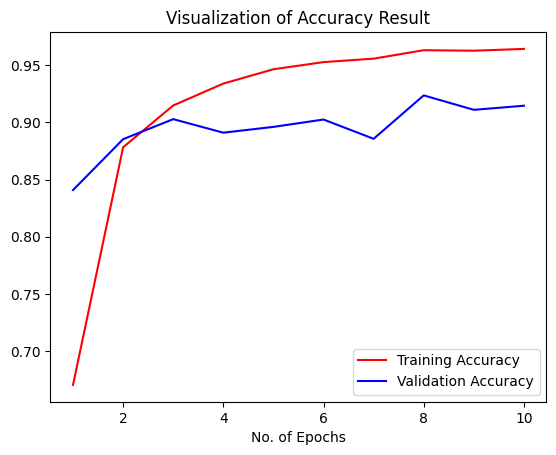

In [19]:
epochs = [i for i in range(1,11)]
plt.plot(epochs,training_history.history['accuracy'],color='red',label='Training Accuracy')
plt.plot(epochs,training_history.history['val_accuracy'],color='blue',label='Validation Accuracy')
plt.xlabel('No. of Epochs')
plt.title('Visualization of Accuracy Result')
plt.legend()
plt.show()

In [20]:
#saving the model
model.save('plant_disease_detection_model.keras')